In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [10]:
X_train= pd.read_csv('../data/UCI HAR Dataset/train/X_train.txt', sep=r'\s+', header=None)
y_train= pd.read_csv('../data/UCI HAR Dataset/train/y_train.txt', sep=r'\s+', header=None)

features=pd.read_csv('../data/UCI HAR Dataset/features.txt', sep=r'\s+', header=None)
X_train.columns = features[1]


X_test = pd.read_csv('../data/UCI HAR Dataset/test/X_test.txt', sep=r'\s+', header=None)
y_test = pd.read_csv('../data/UCI HAR Dataset/test/y_test.txt', sep=r'\s+', header=None)

X_test.columns = features[1]


In [11]:

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)


activity_labels = pd.read_csv('../data/UCI HAR Dataset/activity_labels.txt', sep=r'\s+', header=None)
activity_labels_dict = dict(zip(activity_labels[0], activity_labels[1]))


y_mapped = y[0].map(activity_labels_dict)
y_train_mapped = y_train[0].map(activity_labels_dict)
y_test_mapped = y_test[0].map(activity_labels_dict)


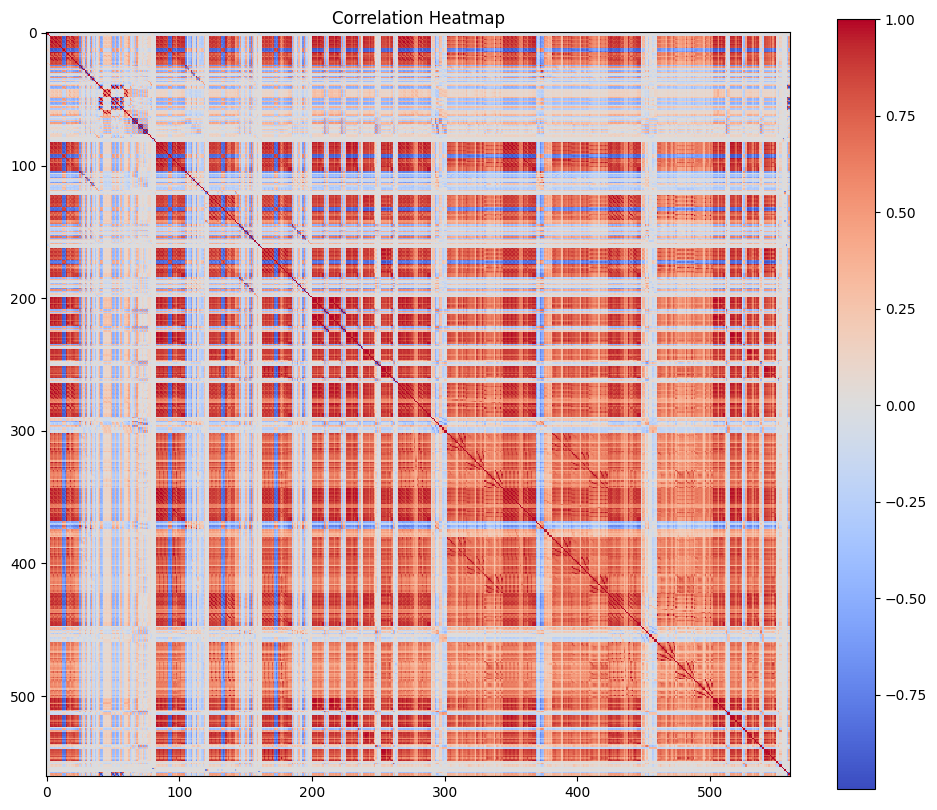

In [12]:
# Create a heatmap
plt.figure(figsize=(12, 10))
plt.imshow(X_train.corr(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Heatmap')
plt.show()


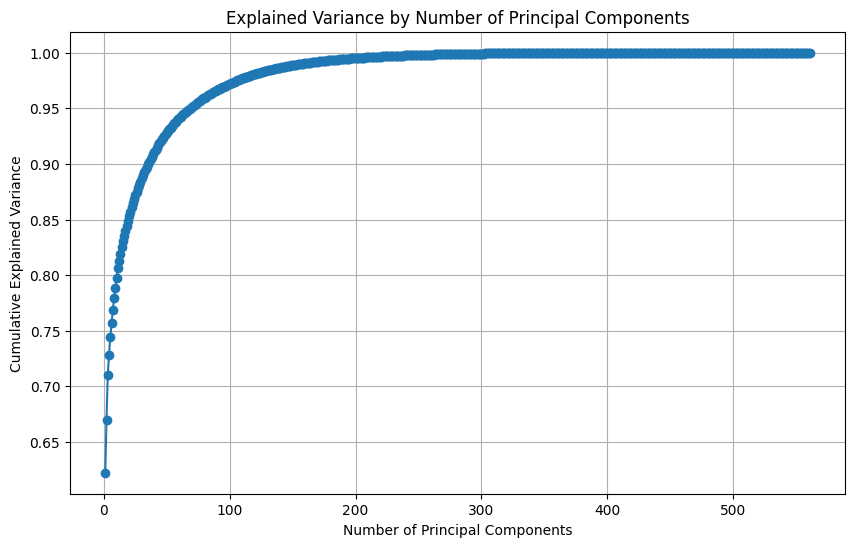

Number of components explaining more than 90.0% of the variance: 36


In [13]:
# Perform PCA without specifying n_components to keep all components
pca = PCA()
pca.fit(X)

# Plot the explained variance for each component
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='-')
plt.title('Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Set a threshold for the explained variance (e.g., 90%)
threshold = 0.90

# Calculate the number of components to retain that explains at least 90% of the variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components = (cumulative_variance >= threshold).argmax() + 1

print(f'Number of components explaining more than {threshold * 100}% of the variance: {n_components}')


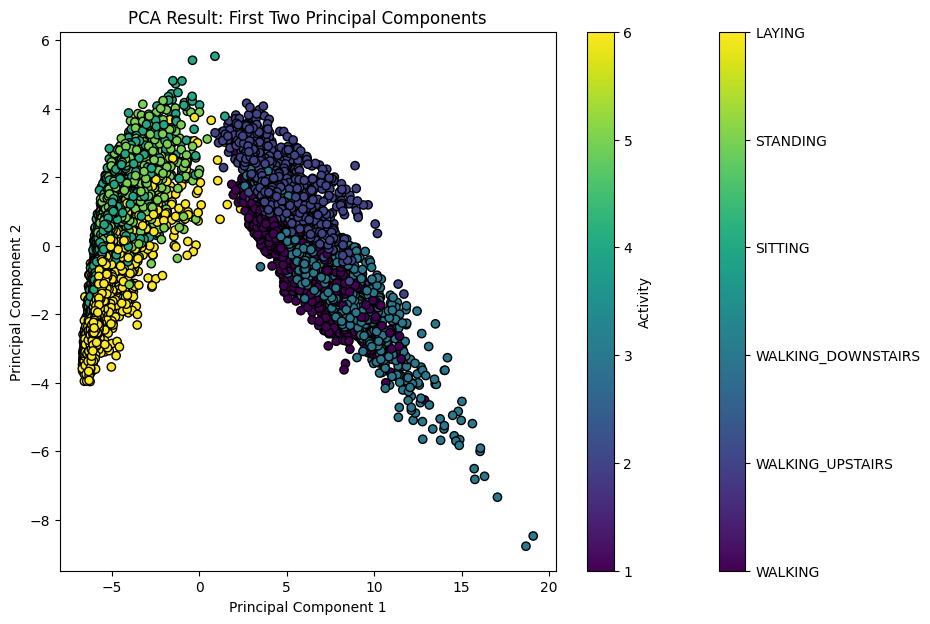

In [14]:
# Perform PCA to reduce the dataset to 36 dimensions
pca = PCA(n_components)
X_pca = pca.fit_transform(X)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)
# Create a scatter plot of the first two principal components
plt.figure(figsize=(10, 7))
scatter=plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k')

# Add a colorbar with label mappings
cbar = plt.colorbar(scatter)
cbar.set_ticks([1, 2, 3, 4, 5,6])
cbar.set_ticklabels(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])

plt.title('PCA Result: First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Activity')
plt.show()


In [15]:
loadings = pd.DataFrame(pca.components_, columns=X.columns, index=[f'PC{i}' for i in range(1, 37)])
loadings_transposed = loadings.T  # Transpose the DataFrame
loadings_transposed.to_csv('pca_loadings_transposed.csv', index=True)


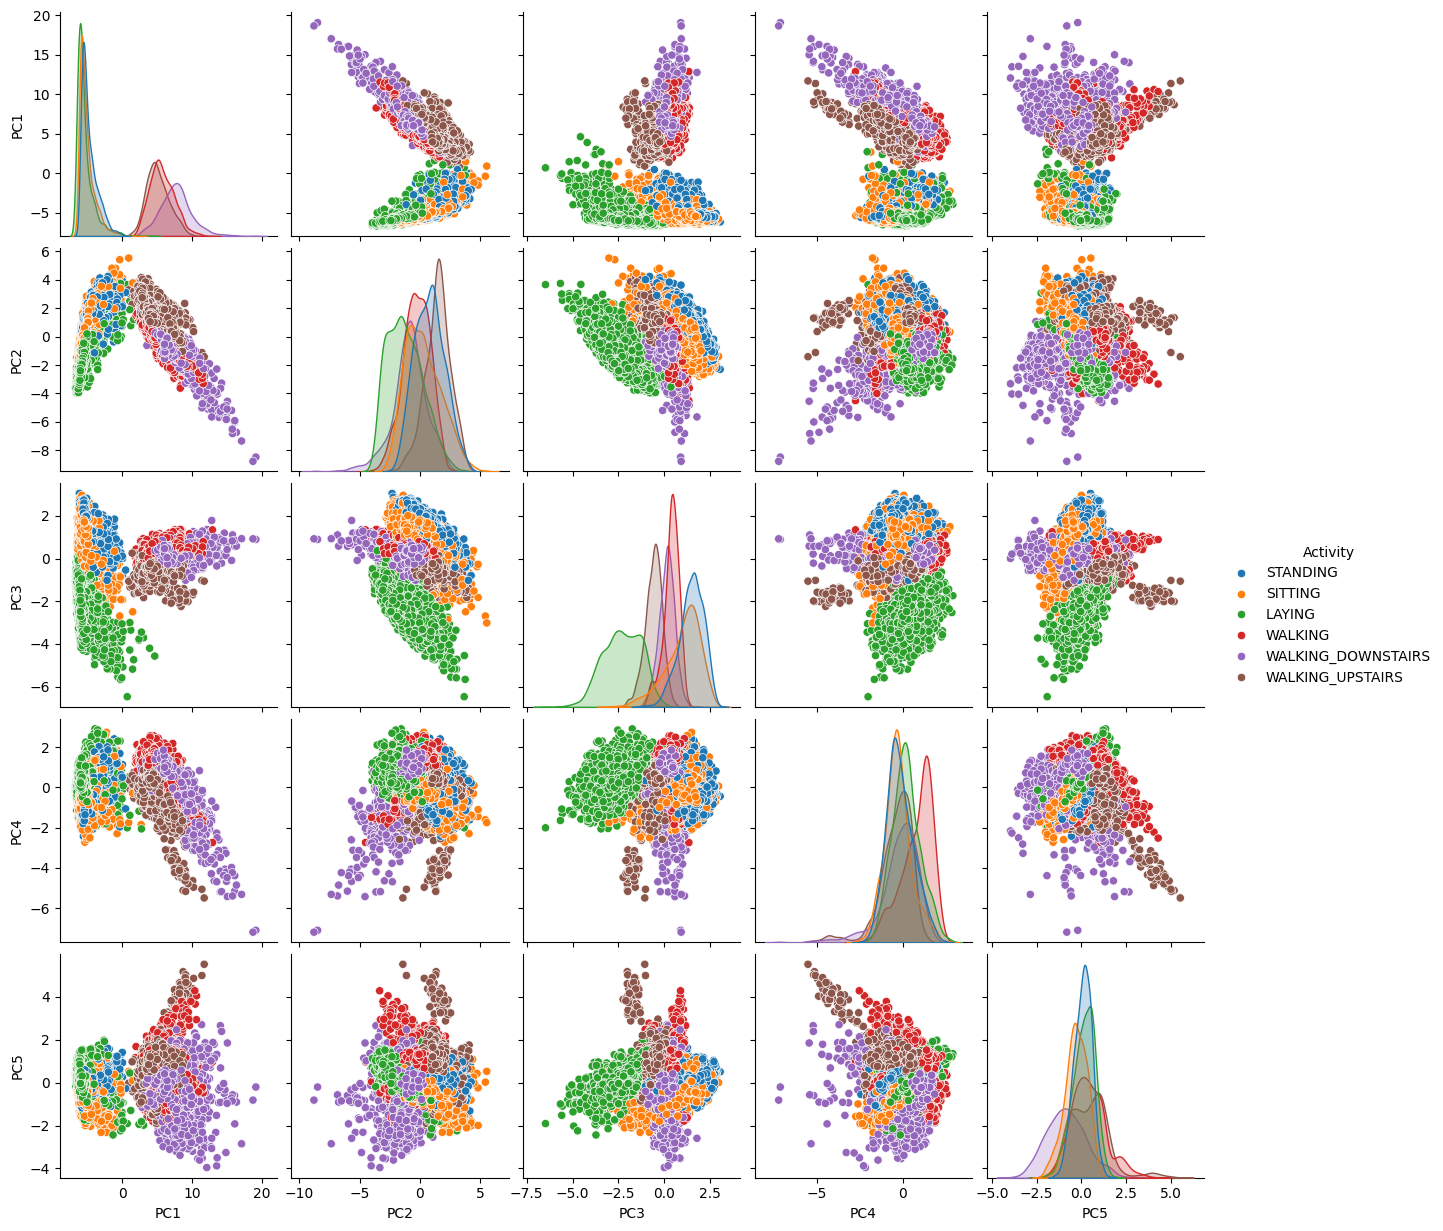

In [16]:
pca_df = pd.DataFrame(X_pca[:, :5], columns=[f'PC{i}' for i in range(1, 6)])
pca_df['Activity'] = y_mapped.values
sns.pairplot(pca_df, hue='Activity')
plt.show()


In [24]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Initialize models
lr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=42)
svm = SVC()

# Define hyperparameter grids
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
param_grid_svm = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}

# Set up GridSearchCV for each model
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5)
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5)

# Fit the models using GridSearchCV
grid_lr.fit(X_train, y_train_mapped)
grid_knn.fit(X_train, y_train_mapped)
grid_rf.fit(X_train, y_train_mapped)
grid_svm.fit(X_train, y_train_mapped)

# Best estimators from GridSearchCV
best_lr = grid_lr.best_estimator_
best_knn = grid_knn.best_estimator_
best_rf = grid_rf.best_estimator_
best_svm = grid_svm.best_estimator_

# Predictions on the test and train set
y_pred_lr_test = best_lr.predict(X_test)
y_pred_lr_train = best_lr.predict(X_train)

y_pred_knn_test = best_knn.predict(X_test)
y_pred_knn_train = best_knn.predict(X_train)

y_pred_rf_test = best_rf.predict(X_test)
y_pred_rf_train = best_rf.predict(X_train)

y_pred_svm_test = best_svm.predict(X_test)
y_pred_svm_train = best_svm.predict(X_train)

# Accuracy scores
test_accuracy_lr = accuracy_score(y_test_mapped, y_pred_lr_test)
train_accuracy_lr = accuracy_score(y_train_mapped, y_pred_lr_train)

test_accuracy_knn = accuracy_score(y_test_mapped, y_pred_knn_test)
train_accuracy_knn = accuracy_score(y_train_mapped, y_pred_knn_train)

test_accuracy_rf = accuracy_score(y_test_mapped, y_pred_rf_test)
train_accuracy_rf = accuracy_score(y_train_mapped, y_pred_rf_train)

test_accuracy_svm = accuracy_score(y_test_mapped, y_pred_svm_test)
train_accuracy_svm = accuracy_score(y_train_mapped, y_pred_svm_train)

# Print the results
print(f'Best Logistic Regression Params: {grid_lr.best_params_}')
print(f'train Accuracy of Logistic Regression with PCA components: {train_accuracy_lr * 100}%')
print(f'test Accuracy of Logistic Regression with PCA components: {test_accuracy_lr * 100}%')

print(f'Best kNN Params: {grid_knn.best_params_}')
print(f'train Accuracy of kNeighbors Classifier with PCA components: {train_accuracy_knn * 100}%')
print(f'test Accuracy of kNeighbors Classifier with PCA components: {test_accuracy_knn * 100}%')

print(f'Best Random Forest Params: {grid_rf.best_params_}')
print(f'train Accuracy of Random Forest Classifier with PCA components: {train_accuracy_rf * 100}%')
print(f'test Accuracy of Random Forest Classifier with PCA components: {test_accuracy_rf * 100}%')

print(f'Best SVM Params: {grid_svm.best_params_}')
print(f'train Accuracy of Support Vector CLassifier with PCA components: {train_accuracy_svm * 100}%')
print(f'test Accuracy of Support Vector CLassifier with PCA components: {test_accuracy_svm * 100}%')


Best Logistic Regression Params: {'C': 10}
train Accuracy of Logistic Regression with PCA components: 99.63275299238302%
test Accuracy of Logistic Regression with PCA components: 96.23345775364778%
Best kNN Params: {'n_neighbors': 7}
train Accuracy of kNeighbors Classifier with PCA components: 98.17736670293797%
test Accuracy of kNeighbors Classifier with PCA components: 90.22734984730234%
Best Random Forest Params: {'max_depth': 20, 'n_estimators': 200}
train Accuracy of Random Forest Classifier with PCA components: 100.0%
test Accuracy of Random Forest Classifier with PCA components: 92.97590770274856%
Best SVM Params: {'C': 10, 'gamma': 'scale'}
train Accuracy of Support Vector CLassifier with PCA components: 99.41512513601741%
test Accuracy of Support Vector CLassifier with PCA components: 96.19952494061758%
